In [7]:
import numpy as np
import sympy as sp
from sympy.matrices import Matrix

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T

In [10]:
def DH(d, theta, a, alpha):
    A = Rz(theta) @ Tz(d) @ Tx(a) @ Rx(alpha)
    return A

In [11]:
# robot parameters, links (m)
l1 = 0.346
l2 = 0.324
l3 = 0.312
l4 = 1.075
l5 = 0.225
l6 = 1.280
l7 = 0.215
d6 = 0.1
q = [0,0,0,0,0,0]

In [12]:
d_p= np.array([l1, 0, 0, l3, 0, d6])
th_p = np.array([np.pi/2, 0, np.pi/2, np.pi/2, 0, 0])
a_p = np.array([0, l2, 0, 0, 0, 0])
al_p = np.array([np.pi/2, 0, np.pi/2, np.pi/2, -np.pi/2, 0])

In [13]:
def FK(q_cor):
    Matrix = np.eye(4)

    for i, q in enumerate(q_cor):
      Matrix = Matrix @ DH(d_p[i], th_p[i]+q, a_p[i], al_p[i])

    return Matrix


In [14]:
def sym_DH(d, theta, a, alpha):
  # returns the pose T of one joint frame i with respect to the previous joint frame (i - 1)
  # given the parameters:
  # theta: theta[i]
  # alpha: alpha[i-1]
  # a: a[i-1]
  # d: d[i]m

  r11, r21 = sp.cos(theta), sp.sin(theta)
  r32, r33 = sp.sin(alpha), sp.cos(alpha)
  r12 = -sp.sin(theta) * sp.cos(alpha)
  r22 = sp.cos(theta) * sp.cos(alpha)
  r13 = sp.sin(theta) * sp.sin(alpha)
  r23 = -sp.cos(theta) * sp.sin(alpha)
  x = a * sp.cos(theta)
  y = a * sp.sin(theta)

  T = Matrix([
    [r11, r12, r13, x],
    [r21, r22, r23, y],
    [0  , r32, r33, d],
    [0.0, 0.0, 0.0, 1]
  ])

  T = sp.simplify(T)

  return T

In [15]:
thetas = sp.symbols(r'\theta_4:7')
sl3 = sp.Symbol(r"l_3")
sd6 = sp.Symbol(r"d_6")

In [16]:
sR36 = sym_DH(sl3, sp.pi/2+thetas[0],0,sp.pi/2) @ sym_DH(0, thetas[1],0,-sp.pi/2) @ sym_DH(sd6, thetas[2],0,0)
sR36

Matrix([
[-sin(\theta_4)*cos(\theta_5)*cos(\theta_6) - sin(\theta_6)*cos(\theta_4),  sin(\theta_4)*sin(\theta_6)*cos(\theta_5) - cos(\theta_4)*cos(\theta_6),  sin(\theta_4)*sin(\theta_5),  d_6*sin(\theta_4)*sin(\theta_5)],
[-sin(\theta_4)*sin(\theta_6) + cos(\theta_4)*cos(\theta_5)*cos(\theta_6), -sin(\theta_4)*cos(\theta_6) - sin(\theta_6)*cos(\theta_4)*cos(\theta_5), -sin(\theta_5)*cos(\theta_4), -d_6*sin(\theta_5)*cos(\theta_4)],
[                                             sin(\theta_5)*cos(\theta_6),                                             -sin(\theta_5)*sin(\theta_6),                cos(\theta_5),          d_6*cos(\theta_5) + l_3],
[                                                                       0,                                                                        0,                            0,                                1]])

In [17]:
def get_cosine_law_angle(a, b, c):
  # given all sides of a triangle a, b, c
  # calculate angle gamma between sides a and b using cosine law
  cos_gamma = (a*a + b*b - c*c) / (2*a*b)
  sin_gamma = np.sqrt(1 - cos_gamma * cos_gamma)
  gamma = np.arctan2(sin_gamma, cos_gamma)

  return gamma

def first_angles(wrist_center):
    x, y, z = wrist_center
    theta1 = np.arctan2(y, x)- np.pi/2
    r = np.sqrt(x**2+y**2)
    h = z - l1
    p = np.sqrt(r**2+h**2)
    alpha = np.arctan2(h, r)
    gamma1 = get_cosine_law_angle(l2, p, l3)
    theta2 = alpha - gamma1
    gamma2 = get_cosine_law_angle(l2, l3, p)
    theta3 = np.pi - gamma2
    return theta1, theta2, theta3


def get_wrist_center(trans):
    position_end = trans[:3,3] # take the position of the end effector
    z_vec = trans[:3,2] # take the z-vecotr of the last 2 frames
    wrist_center = position_end - d6 * z_vec
    return wrist_center

def last_angles(rot):
    q4 = np.arctan2((rot[0,2]),-(rot[1,2]))
    q5 = np.arccos(rot[2,2])
    q6 = np.arctan2(-(rot[2,1]),(rot[2,0]))

    return q4, q5, q6

def IK(trans):
    wrist_center = get_wrist_center(trans)
    q1, q2, q3 = first_angles(wrist_center)
    q = np.array([q1, q2, q3])
    R03 = FK(q)[:3,:3]
    R06 = trans[:3,:3]
    R36 = R03.T @ R06
    q4, q5, q6 = last_angles(R36)
    return q1, q2, q3, q4, q5, q6



In [50]:
q = [np.pi/6, np.pi/8, np.pi/3, np.pi/2, np.pi/3, np.pi/6]
FK(q[:4])[:3,3] - get_wrist_center(FK(q))

array([0., 0., 0.])

In [55]:
q = [np.pi/5,  -np.pi/8, np.pi/6, -np.pi/5, np.pi/3, -np.pi/6]
print(q)
IK(FK(q))

[0.6283185307179586, -0.39269908169872414, 0.5235987755982988, -0.6283185307179586, 1.0471975511965976, -0.5235987755982988]


(0.6283185307179586,
 -0.3926990816987238,
 0.5235987755982987,
 -0.6283185307179587,
 1.047197551196598,
 -0.5235987755982984)

In [170]:
def get_frame(q):
    trans = FK(q)
    O = trans[:3,3]
    vectors = np.hsplit(trans[:3,:3],3)
    return (O, vectors)


def plot_frame(q):
    frames = []
    for i in range(1,len(q)):
        frames.append(get_frame(q[:i]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colours = ["red", "yellow", "green"]
    centers = []
    for frame in frames:
        O = frame[0]
        centers.append(O)
        vectors = frame[1]
        for vector, colour in zip(vectors, colours):
            vlength=np.linalg.norm(vector)
            ax.quiver(O[0],O[1],O[2],vector[0],vector[1],vector[2],
                    pivot='tail',length=vlength/25,arrow_length_ratio=vlength/10, color = colour)
    centers = np.concatenate(centers).reshape(-1,3)
    x, y, z = centers[:, 0], centers[:, 1], centers[:, 2]
    ax.scatter(x,y,z, c='b',s=100)
    ax.plot(x,y,z, color='b')
    ax.set_xlim([-0.35, 1])
    ax.set_ylim([-0.3, 1])
    ax.set_zlim([0, 1])
    #plt.show()

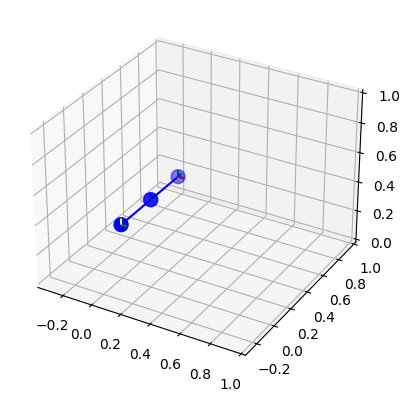

In [171]:
#plot_frame(FK(np.array([0])))
q = [0, 0, 0, 0, 0, 0]
#q = [np.pi/6, np.pi/8, np.pi/3, np.pi/2, np.pi/3, np.pi/6]
plot_frame(q)